# Hyperview

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.stats import norm
from torch import Tensor
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

## Dataset
Ignoring image masks for now, using regular images and cropping them to 60x60.

In [3]:
class HyperviewDataset(Dataset):
    def __init__(self, directory: str) -> None:
        super().__init__()
        self.images = self.load_images(directory)
        self.transform = transforms.Compose([transforms.CenterCrop(50)])#, transforms.Normalize(0, 5375)]) # divide by max

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> Tensor:
        image = self.transform(self.images[index])
        return image

    @staticmethod
    def load_images(directory: str) -> list[Tensor]:
        filenames = Path(directory).rglob("*.npz")
        image_list = []
        for filename in filenames:
            with np.load(filename) as npz:
                arr = np.ma.MaskedArray(**npz)
                image_list.append(torch.from_numpy(arr.data).float())
        return image_list

In [4]:
dataset = HyperviewDataset("/home/zuzg/uni/representation-hyperview/data/hyperview/train_data/train_data")

In [5]:
len(dataset)

1732

In [7]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [1500, 100, 132])

In [8]:
trainloader = DataLoader(train_set, batch_size=8, shuffle=True)
valloader = DataLoader(val_set, batch_size=8)

## Architectures

### Modeller
Output shaped N x K x 3 x H x W, K-number of triples (intensity, mu, std) describing distributions.

In [9]:
class Modeller(nn.Module):
    def __init__(self, channels: int = 150, k: int = 10):
        super(Modeller, self).__init__()
        self.k = k
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 3 * self.k, kernel_size=1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(x.shape[0], self.k, 3, 50, 50)
        return x

### Renderer

In [10]:
class Renderer:
    def __init__(self) -> None:
        pass

    def __call__(self, batch: Tensor) -> Tensor:
        batch_size, k, params, h, w = batch.shape
        self.bands = torch.arange(150).float().repeat(k, h, w, 1).to(DEVICE)
        rendered = torch.zeros((batch_size, 150, h, w))

        for idx in range(batch_size):
            dists = self.generate_distribution(
                batch[idx, :, 0, ...], batch[idx, :, 1, ...], batch[idx, :, 2, ...]
            )
            pixel_dist = torch.sum(dists, dim=0)
            rendered[idx] = pixel_dist.permute(2, 0, 1)

        return rendered.to(DEVICE)

    def generate_distribution(
        self, intensity: Tensor, mu: Tensor, std: Tensor
    ):
        eps = 1e-4
        std = torch.add(std, eps)
        normal_dist = Normal(mu.unsqueeze(-1), std.unsqueeze(-1))
        return intensity.unsqueeze(-1) * torch.exp(normal_dist.log_prob(self.bands))

#### Example of rendering

In [11]:
# two example hats
hat1 = [10, 75, 10]
hat2 = [2, 100, 2]

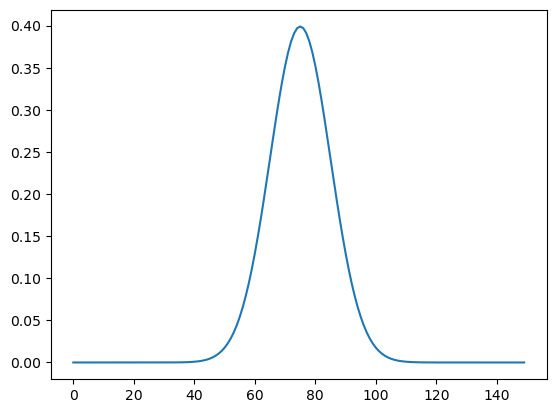

In [12]:
dist1 = hat1[0] * norm.pdf(range(0, 150), hat1[1], hat1[2])
plt.plot(dist1)

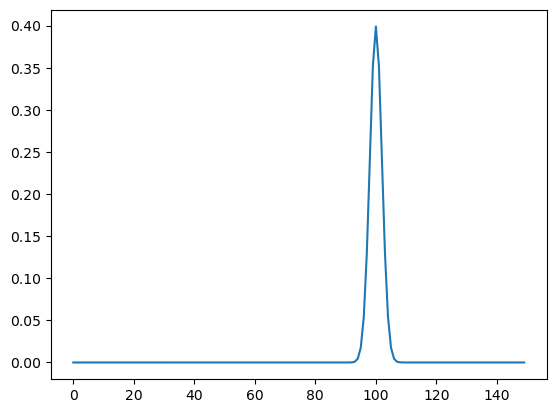

In [13]:
dist2 = hat2[0] * norm.pdf(range(0, 150), hat2[1], hat2[2])
plt.plot(dist2)

In [14]:
# reshaping to input compatible with renderer
t = Tensor([[[10, 75, 10], [2, 100, 2]]]).unsqueeze(-1).unsqueeze(-1).to(DEVICE)
t.shape

torch.Size([1, 2, 3, 1, 1])

In [15]:
renderer = Renderer()
rendered = renderer(t)

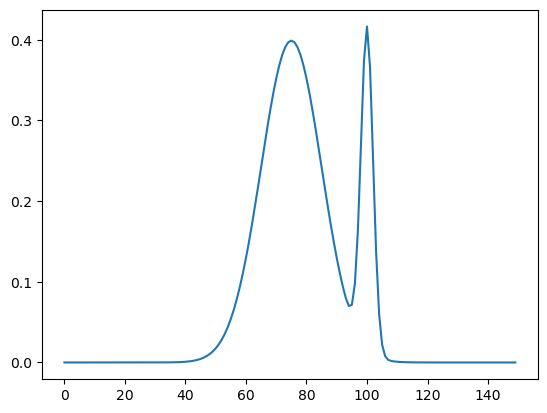

In [16]:
# two hats combined
plt.plot(rendered[0][:,0,0].cpu())

## Training

In [17]:
def train(
    model: nn.Module,
    trainloader: DataLoader,
    valloader: DataLoader,
    num_epochs: int,
    device: str,
    lr: float,
) -> tuple[nn.Module, list[float], list[float]]:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    renderer = Renderer()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        step_losses = []
        with tqdm(trainloader, unit="batch") as tepoch:
            for input in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                optimizer.zero_grad()
                input = input.to(device)
                y_pred = model(input)
                y_pred_r = renderer(y_pred)
                loss = criterion(y_pred_r, input)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
                step_losses.append(loss.cpu().detach().numpy())
        train_losses.append(np.mean(step_losses))
        model.eval()
        running_vloss = 0.0
        with torch.no_grad():
            for i, vdata in enumerate(valloader):
                vinputs= vdata.to(device)
                voutputs = model(vinputs)
                voutputs_r = renderer(voutputs)
                vloss = torch.sqrt(criterion(voutputs_r, vinputs))
                running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        val_losses.append(avg_vloss.cpu())
        scheduler.step()
    return model, train_losses, val_losses

In [18]:
model = Modeller(k=5).to(DEVICE)
model, tloss, vloss = train(model, trainloader, valloader, 50, DEVICE, 1e-5)

Epoch 0:   0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 49: 100%|██████████| 188/188 [00:05<00:00, 34.79batch/s, loss=8.18e+5]


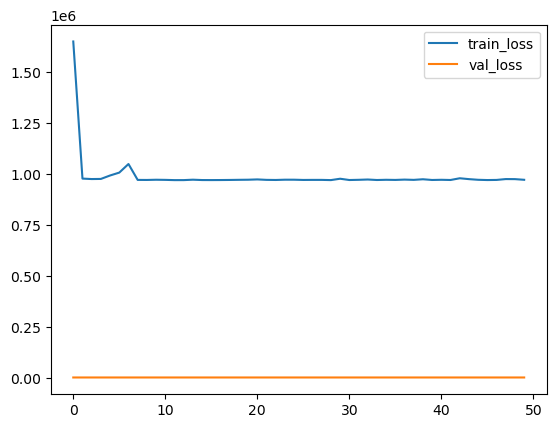

In [58]:
plt.plot(tloss, label="train_loss")
plt.plot(vloss, label="val_loss")
plt.legend()
plt.show()

## Results

In [37]:
renderer = Renderer()
imgs = []
outputs = []
for img in valloader:
    out = model(img.to(DEVICE))
    rendered = renderer(out)
    imgs.append(img)
    outputs.append(rendered)

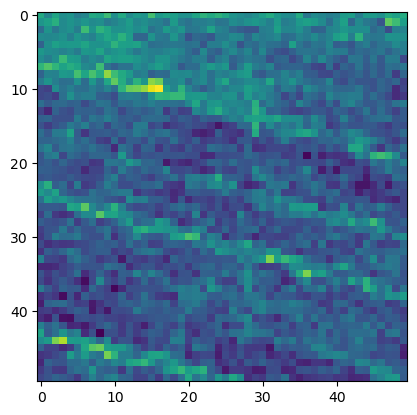

In [44]:
# original image - band0
plt.imshow(imgs[0][0,0])

In [42]:
outputs[0].shape

torch.Size([8, 150, 50, 50])

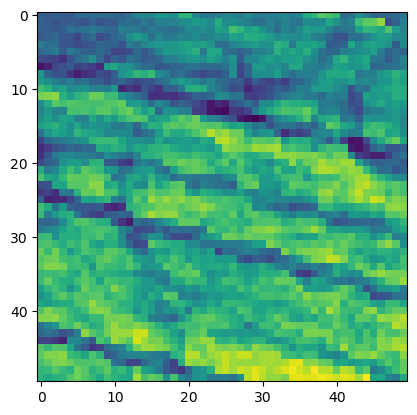

In [51]:
# reconstructed image - band0
plt.imshow(outputs[0][0, 0].cpu().detach().numpy())

In [24]:
rendered[0,0].max(), rendered[0,0].min()

(tensor(0.1975, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(9.1848e-05, device='cuda:0', grad_fn=<MinBackward1>))

Issue: seems like all the hats are accumulated in the first band?

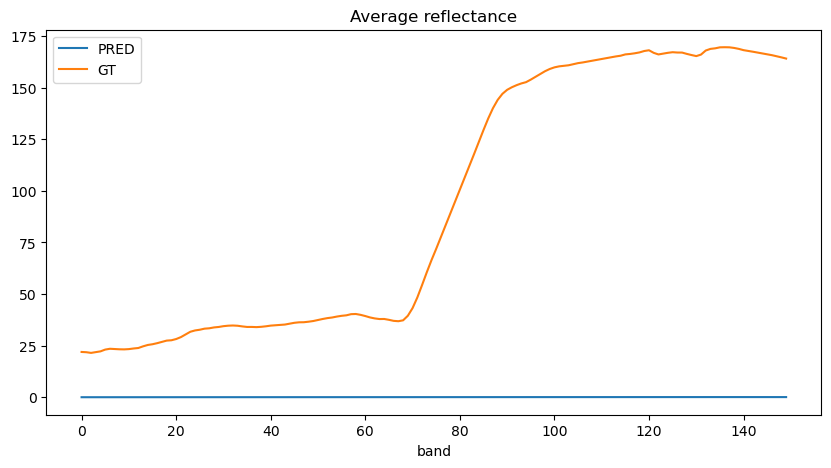

In [53]:
gt_img = img[0]
pred_img = rendered[0].cpu().detach().numpy()
fig = plt.figure(figsize=(10, 5))

gt_mean_spectral_reflectance = [gt_img[i].mean() for i in range(gt_img.shape[0])]
pred_mean_spectral_reflectance = [pred_img[i].mean() for i in range(pred_img.shape[0])]

plt.plot(pred_mean_spectral_reflectance, label="PRED")
plt.plot(gt_mean_spectral_reflectance, label="GT")

plt.xlabel("band")
plt.legend()
plt.title("Average reflectance")
plt.show()

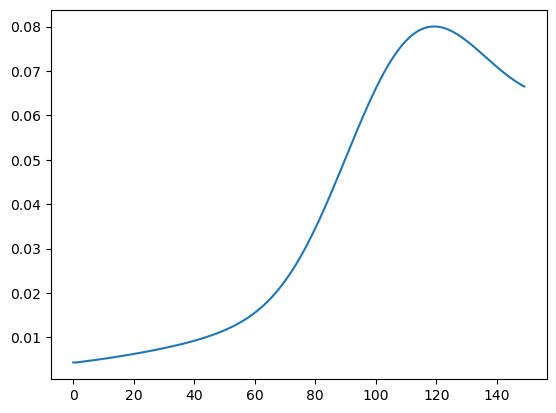

In [54]:
plt.plot(pred_mean_spectral_reflectance, label="PRED")

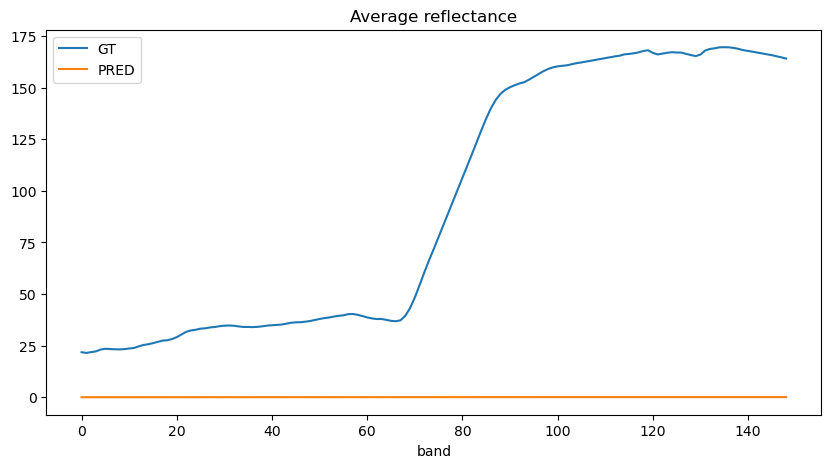

In [26]:
fig = plt.figure(figsize=(10, 5))

gt_mean_spectral_reflectance = [gt_img[i].mean() for i in range(1, gt_img.shape[0])]
pred_mean_spectral_reflectance = [pred_img[i].mean() for i in range(1, pred_img.shape[0])]

plt.plot(gt_mean_spectral_reflectance, label="GT")
plt.plot(pred_mean_spectral_reflectance, label="PRED")

plt.xlabel("band")
plt.legend()
plt.title("Average reflectance")
plt.show()